# Caption Generating Model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
import keras.utils as image
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add
import collections

2023-06-28 15:44:39.314474: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 15:44:39.363970: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 15:44:39.596096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 15:44:39.598489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 15:44:41.190602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
#Function to read text files
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [6]:
captions = readTextFile('Flickr8k.token.txt')

In [7]:
captions=captions.split('\n')[:-1]

In [10]:
# captions[0].split('\t')[0].split('.')[0]
# print(len(captions))

In [11]:
## Creating Dictionary which will map image to caption

In [12]:
descriptions = {}
for x in captions:
    first,second = x.split("\t")
    img_name = first.split(".")[0]
    
    #if image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
        
    descriptions[img_name].append(second)

In [14]:
# descriptions["1000268201_693b08cb0e"]

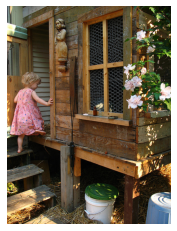

In [16]:
IMG_PATH = "/home/golu/Desktop/Project/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

## Data Cleaning

In [17]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [19]:
# clean_text("A cat is sitting over the house # 65")

In [20]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        

In [22]:
# print(descriptions["1000268201_693b08cb0e"])
# print(type(descriptions))

In [23]:
# Writing the data to text file
with open("descriptions_1.txt","w") as f:
        f.write(str(descriptions))

## Vocabulary

In [24]:
descriptions = None
with open("descriptions_1.txt","r") as f:
    descriptions=f.read()

descript = descriptions.replace("'","\"")
descriptions=json.loads(descript)

In [26]:
# print(type(descriptions))

In [28]:
# descriptions["2513260012_03d33305cf"]

In [29]:
# Voacb to store unique words
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [32]:
# Total words accross all the sentence 
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
# print("total words %d"%len(total_words))

In [34]:
# Filter Words from the Vocab according to certain threshold frequency

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
# print(len(freq_cnt))
# print(len(counter))

In [35]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

#Filter
threshold =10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [39]:
# print(len(total_words)) ## done with the data cleaning here total words is list of unique words
# print(len(sorted_freq_cnt))

# Prepare Train/Test Data

In [40]:
train_file_data = readTextFile("/home/golu/Desktop/Project/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/home/golu/Desktop/Project/Flickr_8k.testImages.txt")

In [41]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [43]:
# print(train_file_data)

In [39]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data

In [44]:
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [46]:
# train_descriptions["1000268201_693b08cb0e"]

# Transfer Learning

## Step - 1 Image Feature Extraction

In [55]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary() # Model will be used in feature extraction

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [57]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [58]:
model_new = Model(model.input,model.layers[-2].output)

In [59]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    # Normalization
    img = preprocess_input(img)
    return img
    
     

In [62]:
# img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
# plt.imshow(img[0])
# plt.axis('off')
# plt.show()
# print(img)

In [78]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [79]:
encode_img(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 0s 186ms/step


array([0.0653658 , 0.16782746, 0.32518446, ..., 0.05111524, 0.3281793 ,
       1.0043328 ], dtype=float32)

In [ ]:
start = time()
encoding_train = {}
#image_id --> feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/" + img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    
    if ix%100==0:
        print("Encoding in Progress Time step %d"%ix)
        
end_t = time()
print("Total Time Taken :", end_t-start)

1/1 [==============================] - 0s 227ms/step
Encoding in Progress Time step 0
1/1 [==============================] - 0s 174ms/step
Encoding in Progress Time step 100
1/1 [==============================] - 0s 183ms/step
Encoding in Progress Time step 200
1/1 [==============================] - 0s 176ms/step
Encoding in Progress Time step 300
1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 178ms/step
Encoding in Progress Time step 400
1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 163ms/step
Encoding in Progress Time step 500
1/1 [==============================] - 0s 181ms/step
Encoding in Progress Time step 600
1/1 [==============================] - 0s 173ms/step
Encoding in Progress Time step 700
1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 177ms/step
Encoding in Progress Time step 800
1/1 [==============================] - 0s 182ms/step
Encoding in Progress Time step 900
1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 1000
1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 177ms/step
Encoding in Progress Time step 1100
1/1 [==============================] - 0s 181ms/step
Encoding in Progress Time step 1200
1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 1300
1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 182ms/step
Encoding in Progress Time step 1400
1/1 [==============================] - 0s 178ms/step
Encoding in Progress Time step 1500
1/1 [==============================] - 0s 180ms/step
Encoding in Progress Time step 1600
1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 179ms/step
Encoding in Progress Time step 1700
1/1 [==============================] - 0s 179ms/step
Encoding in Progress Time step 1800
1/1 [==============================] - 0s 184ms/step
Encoding in Progress Time step 1900
1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 172ms/step
Encoding in Progress Time step 2000
1/1 [==============================] - 0s 176ms/step
Encoding in Progress Time step 2100
1/1 [==============================] - 0s 174ms/step
Encoding in Progress Time step 2200
1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 2300


1/1 [==============================] - 0s 174ms/step
Encoding in Progress Time step 2400
1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 2500
1/1 [==============================] - 0s 174ms/step
Encoding in Progress Time step 2600
1/1 [==============================] - 0s 180ms/step
Encoding in Progress Time step 2700
1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 183ms/step
Encoding in Progress Time step 2800
1/1 [==============================] - 0s 179ms/step
Encoding in Progress Time step 2900
1/1 [==============================] - 0s 168ms/step
Encoding in Progress Time step 3000
1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 172ms/step
Encoding in Progress Time step 3100
1/1 [==============================] - 0s 181ms/step
Encoding in Progress Time step 3200
1/1 [==============================] - 0s 178ms/step
Encoding in Progress Time step 3300
1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 179ms/step
Encoding in Progress Time step 3400
1/1 [==============================] - 0s 189ms/step
Encoding in Progress Time step 3500
1/1 [==============================] - 0s 174ms/step
Encoding in Progress Time step 3600
1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 178ms/step
Encoding in Progress Time step 3700
1/1 [==============================] - 0s 179ms/step
Encoding in Progress Time step 3800
1/1 [==============================] - 0s 178ms/step
Encoding in Progress Time step 3900
1/1 [==============================] - 0s 182ms/step


1/1 [==============================] - 0s 172ms/step
Encoding in Progress Time step 4000
1/1 [==============================] - 0s 168ms/step
Encoding in Progress Time step 4100
1/1 [==============================] - 0s 177ms/step
Encoding in Progress Time step 4200
1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 174ms/step
Encoding in Progress Time step 4300
1/1 [==============================] - 0s 177ms/step
Encoding in Progress Time step 4400
1/1 [==============================] - 0s 176ms/step
Encoding in Progress Time step 4500
1/1 [==============================] - 0s 176ms/step
Encoding in Progress Time step 4600
1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 180ms/step
Encoding in Progress Time step 4700
1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 178ms/step
Encoding in Progress Time step 4800
1/1 [==============================] - 0s 183ms/step
Encoding in Progress Time step 4900
1/1 [==============================] - 0s 170ms/step
Encoding in Progress Time step 5000
1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 5100
1/1 [==============================] - 0s 357ms/step
Encoding in Progress Time step 5200
1/1 [==============================] - 0s 480ms/step
Encoding in Progress Time step 5300
1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 308ms/step
Encoding in Progress Time step 5400
1/1 [==============================] - 0s 484ms/step
Encoding in Progress Time step 5500
1/1 [==============================] - 0s 311ms/step
Encoding in Progress Time step 5600
1/1 [==============================] - 0s 484ms/step


1/1 [==============================] - 1s 549ms/step
Encoding in Progress Time step 5700
1/1 [==============================] - 0s 363ms/step
Encoding in Progress Time step 5800
1/1 [==============================] - 1s 526ms/step
Encoding in Progress Time step 5900
1/1 [==============================] - 1s 737ms/step


In [ ]:
# Storing everything to the disk
with open("encoded_train_features.pk1","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
# For test feature also
start = time()
encoding_test = {}
#image_id --> feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/" + img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    
    if ix%100==0:
        print("Encoding in Progress Time step %d"%ix)
        
end_t = time()
print("Total Time Taken :", end_t-start)


In [ ]:
with open("encoded_test_features.pk1","wb") as f:
    pickle.dump(encoding_test,f)

In [80]:
with open("encoded_train_features.pkl","rb") as f:
    encoding_train = pickle.load(f)

In [81]:
with open("encoded_test_features.pkl","rb") as f:
    encoding_test = pickle.load(f)

## Data preprocessing for Captions

In [84]:
# Vocab
len(total_words)

1845

In [85]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [86]:
with open("word_to_idx.pkl",'wb') as f:
    pickle.dump(word_to_idx,f)

In [87]:
# word_to_idx["dog"]
# idx_to_word[1]
print(len(idx_to_word))

1845


In [88]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx)+1
print("vacab_size ",vocab_size)


vacab_size  1848


In [89]:
with open("idx_to_word",'wb') as f:
    pickle.dump(idx_to_word,f)

In [90]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)        

35


In [91]:
# Data Loader (Generator)

In [92]:
def data_generator(train_descriptions, encoding_train,word_to_idx,max_len,batch_size):
    x1,x2,y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],maxlen = max_len, value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield[[np.array(x1),np.array(x2)],np.array(y)]
                    x1,x2,y = [],[],[]
                    n=0
            
    

## Word Embedding

In [93]:
f = open("glove.6B.50d.txt",encoding='utf8')

In [94]:
embedding_index ={}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [95]:
f.close()
# embedding_index['apple']

In [96]:
#defining embedding matrix

def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
            

In [97]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [98]:
#embedding_matrix[1847] all zeros because "endseq" is not in glove

## Model Architecture

In [99]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [100]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [101]:
decorder1 = add([inp_img2,inp_cap3])
decorder2 = Dense(256,activation='relu')(decorder1)
outputs = Dense(vocab_size,activation='softmax')(decorder2)

In [102]:
# Combining Model
model = Model(inputs = [input_img_features,input_captions],outputs=outputs)

In [103]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

In [104]:
# Important Thing -- Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [105]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [106]:
# Training of Model Parameters
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [107]:
# with open('encoded_train_features.pkl', 'rb') as f:
#     encoding_train = pickle.load(f)

In [109]:
# Model Training
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=0)
    model.save('./model_weights2/model_'+str(i)+'.h5')
        

/tmp/ipykernel_7793/986837850.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=0)
2023-06-28 16:29:27.430337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-28 16:38:21.107505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-28 16:46:49.943333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (D

In [110]:
model.save("caption_project2.h5")


In [115]:
model = load_model("caption_project2.h5")

## Model Testing on Test Dataset

In [182]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += ' ' + word
        
        if word=='endseq':
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

1/1 [==============================] - 0s 39ms/step


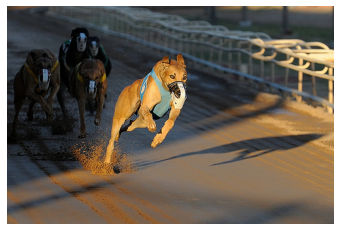

[[0.5706982  0.55971247 0.9935432  ... 0.4172727  0.5930016  0.        ]]
dog running on the beach
1/1 [==============================] - 0s 51ms/step


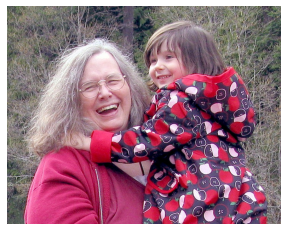

[[0.30596933 0.9908514  0.06436859 ... 0.         0.31409886 0.35043412]]
young boy in red shirt is pointing down in the grass
1/1 [==============================] - 0s 49ms/step


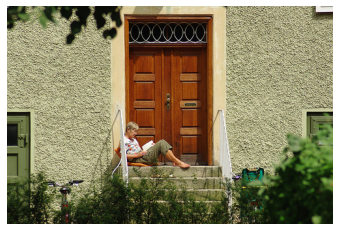

[[0.261977   0.16145097 0.66734344 ... 0.314714   0.         0.41968295]]
little girl in pink pajamas is jumping over an open lawn
1/1 [==============================] - 0s 50ms/step


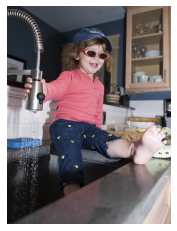

[[0.3623592  1.0224972  0.42229632 ... 0.43332228 0.6063106  1.6015502 ]]
little boy in camouflage shirt is kneeling on the floor
1/1 [==============================] - 0s 40ms/step


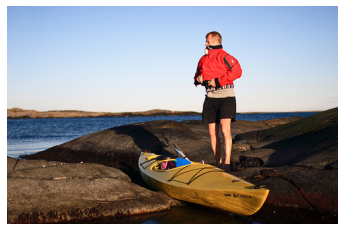

[[0.27433634 0.7646833  0.04557046 ... 0.06076672 2.379702   0.43906674]]
two men are sitting on the edge of lake


In [141]:
for i in range(5):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoded_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoded_test[img_name].reshape((1,2048))
    
    i = plt.imread("Images/"+img_name+".jpg")
    caption = predict_caption(photo_2048)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    print(photo_2048)
    print(caption)    

## Test on Random Images

In [132]:
from skimage import io

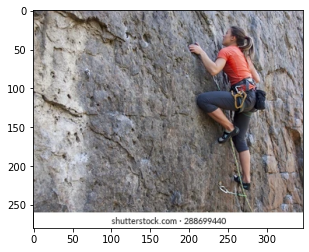

In [178]:
img = io.imread("/home/golu/Downloads/young-woman-rope-engaged-sports-260nw-288699440.webp")
plt.imshow(img)

In [179]:
x = encode_img("/home/golu/Downloads/young-woman-rope-engaged-sports-260nw-288699440.webp").reshape((1,2048))

1/1 [==============================] - 1s 889ms/step


In [183]:
print(predict_caption(x))

[[0.842964   1.9256011  0.0832765  ... 0.10063877 0.31258973 0.05901907]]
1/1 [==============================] - 0s 67ms/step
man climbing rock face
